# Evaluating Machine Learning models

-  Chapter 4, Section 3 of [Deep Learning with Python, v2](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff)

-  Chapter 5, Section 3 of [Deep Learning Book](https://www.deeplearningbook.org/contents/ml.html)


In the previous notebooks, we have underlined that the goal of a machine learning model is to generalize well on previously unseen examples. Overfitting indeed represents a central issue in the training process. 

Relying on a **validation set** allows us to measure the generalization capability during training, and to take strategic countermeasures to mitigate overfitting. 

**It is of the utmost importance that the test set is not used to make choices about the model and the selection of its hyperparameters**: the examples of the test set must not be used in the validation set. Therefore, we must construct the validation set using examples from training data. 

Let's recap the most common approaches for a fair evaluation of the generalization capability of our model during training.

## Simple hold-out validation 
In the simple hold-out validation we split the training data into two disjoint subsets. 
- The training subset is used to learn the parameters. 
- The validation subset is used to estimate the generalization capability during training: we are allowed to tune the hyperparameters accordingly to the performance on this subset.

A typical split is 80/20: 80 percent of the training data are used for training while the remaining 20 percent are used for validation. 

Since the validation set is used to tune the hyperparameters, we may encounter again a slighter overfitting: the validation set error will underestimate the real generalization error (measured on the test set). 

At the end of the hyperparameter optimization procedure, the performance of our model may be estimated using the test set.



```python
num_validation_samples = len(data)*0.2
np.random.shuffle(data) # Shuffling the data is usually appropriate.

validation_data = data[:num_validation_samples]
data = data[num_validation_samples:]
training_data = data[:]
# Note: labels must be split accordingly

model = get_model()
model.train(training_data)
validation_score = model.evaluate(validation_data)

# At this point you can tune your model,
# retrain it, evaluate it, tune it again...

# Then, finally:
model = get_model()
model.train(np.concatenate([training_data, validation_data]))
test_score = model.evaluate(test_data)
```


## K-fold cross-validation

The **simple hold-out validation approach can be problematic if the resulting validation set is small**: the sampled validation examples may not be representative of the actual distribution of our dataset. Training (and validating) our model on different random splits would results in different values of model performance. In other words, we may observe statistical uncertainty around the estimated average test error.

To address this issue, *k*-fold cross validation is commonly adopted.
The procedure consists in the following steps:
- the dataset is split in *k* non-overlapping subset
- for each subset *i* the model is tested on the *i-th* subset itself and trained on the union of the remaining *k-1* subsets,
- after *k* iteration, we can rely on *k* values of model performance: the final score is obtained averaging the scores across the *k* trials.

Using k-fold cross-validation allows to estimate the average test error using all the examples, at the price of an increased runtime (k training procedures)

![alt text](https://upload.wikimedia.org/wikipedia/commons/1/1c/K-fold_cross_validation_EN.jpg)



```python
k = 4
np.random.shuffle(data) # Shuffling the data is usually appropriate.
num_val_samples = len(data) // k
validation_scores = []

for fold in range(k):
    # validation data: data from partition k
    val_data = data[fold * num_val_samples: (fold + 1) * num_val_samples]
    # training data: data from all other partitions
    train_data = np.concatenate([data[:fold * num_val_samples],  data[(fold+ 1) * num_val_samples:]], axis=0)
    # Note: labels must be split accordingly

    # Build the Keras model
    model = get_model() # create a brand new instance of the model at each iteration
    model.train(training_data)
    # Evaluate the model on the validation data
    validation_score = model.evaluate(validation_data)
    validation_scores.append(validation_score)    
    # it is better to delete the model and clear session to free memory
    
# validation score: average of the validation scores of the k folds
validation_score = np.average(validation_scores)
model = get_model()

# train the final model on all non-test data available
model.train(data)
test_score = model.evaluate(test_data)
```

For both *single hold-out validation* and *k-fold cross-validation* we can resort to the implementation provided in the `model_selection` module provided in the `scikit-learn` (sklearn) library.

- `train_test_split`: [link to the docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- `StratifiedKFold` [link to the docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html?highlight=stratified#sklearn.model_selection.StratifiedKFold)

`scikit-learn` is a Python package designed to give access to well-known machine learning algorithms within Python code, through a clean, well-thought-out API. It has been built by hundreds of contributors from around the world, and is used across industry and academia. It is built upon Python's `numpy` (Numerical Python) and `scipy` (Scientific Python) libraries. 

## Classification Evaluation Metrics

Suppose we are tackling a 2 classes classification problem.
Let `y_true` be the true labels of our test samples and `y_pred` be the labels predicted by our classification model.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

# Import data
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binary classification
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

num_classes = len(np.unique(y))
print(f'Classes: {np.unique(y)}')

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.concatenate((X, random_state.randn(n_samples, n_features)), axis=1)
n_samples, n_features = X.shape

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(15, input_shape=(n_features,), activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model and start training
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, pd.get_dummies(y_train), epochs=60, batch_size=X_train.shape[0], validation_split=0.2)

# Test the model after training
test_results = model.evaluate(X_test, pd.get_dummies(y_test), verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

y_score = model.predict(X_test)
y_pred = np.argmax(y_score, axis=1)

Classes: [0 1]
Epoch 1/60
1/1 [==============================] - 1s 1s/step - loss: 1.0186 - accuracy: 0.4833 - val_loss: 0.7634 - val_accuracy: 0.6000
Epoch 2/60
1/1 [==============================] - 0s 66ms/step - loss: 1.0070 - accuracy: 0.4833 - val_loss: 0.7561 - val_accuracy: 0.6000
Epoch 3/60
1/1 [==============================] - 0s 131ms/step - loss: 0.9957 - accuracy: 0.4833 - val_loss: 0.7489 - val_accuracy: 0.6000
Epoch 4/60
1/1 [==============================] - 0s 58ms/step - loss: 0.9846 - accuracy: 0.4833 - val_loss: 0.7419 - val_accuracy: 0.6000
Epoch 5/60
1/1 [==============================] - 0s 38ms/step - loss: 0.9737 - accuracy: 0.4833 - val_loss: 0.7350 - val_accuracy: 0.6000
Epoch 6/60
1/1 [==============================] - 0s 63ms/step - loss: 0.9631 - accuracy: 0.4833 - val_loss: 0.7282 - val_accuracy: 0.6000
Epoch 7/60
1/1 [==============================] - 0s 98ms/step - loss: 0.9527 - accuracy: 0.4833 - val_loss: 0.7217 - val_accuracy: 0.6000
Epoch 8/60
1/

**[scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)** offers utilities for metrics evaluation. Let's see the most relevant ones.

In [2]:
from sklearn import metrics

In [3]:
# confusion matrix: 
#     on each row: true class
#     on each column: predicted class
metrics.confusion_matrix(y_test, y_pred)

array([[ 2, 11],
       [ 0, 12]])

Confusion matrix cells can be immediately mapped to the cells of this table:

<img src="https://miro.medium.com/max/2102/1*fxiTNIgOyvAombPJx5KGeA.png" alt="drawing" width="450"/>


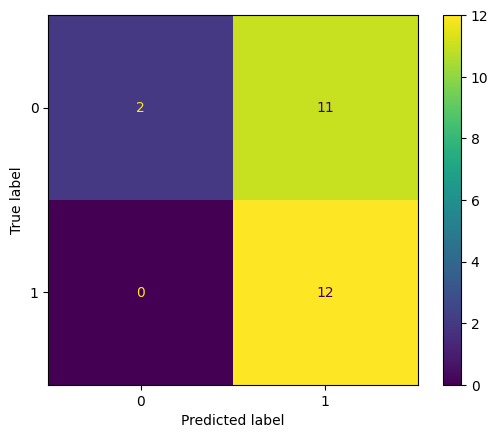

In [4]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot()
plt.show()

In [5]:
# accuracy: (TP+TN)/(TP+FP+FN+TN): percentage of correctly predicted samples
metrics.accuracy_score(y_test, y_pred)

0.56

In [6]:
# precision: TP/(TP+FP): The precision is intuitively the ability of the classifier not to label as positive a sample that is negative (i.e., minimizing FP)
metrics.precision_score(y_test, y_pred)

0.5217391304347826

In [7]:
# recall: TP/(TP+FN): The recall is intuitively the ability of the classifier to find all the positive samples (i.e., minimizing FN)
metrics.recall_score(y_test, y_pred)

1.0

In [8]:
# f1-score: 2*(precision*recall)/(precision + recall). The F1-score is the harmonic mean of precision and recall
metrics.f1_score(y_test, y_pred)

0.6857142857142856

In [9]:
# classification report: Build a text report showing the main classification metrics
print(metrics.classification_report(y_test, y_pred, digits = 5))

              precision    recall  f1-score   support

           0    1.00000   0.15385   0.26667        13
           1    0.52174   1.00000   0.68571        12

    accuracy                        0.56000        25
   macro avg    0.76087   0.57692   0.47619        25
weighted avg    0.77043   0.56000   0.46781        25



If we resort to the probability score of our classification model, we can evaluate the ROC curve.

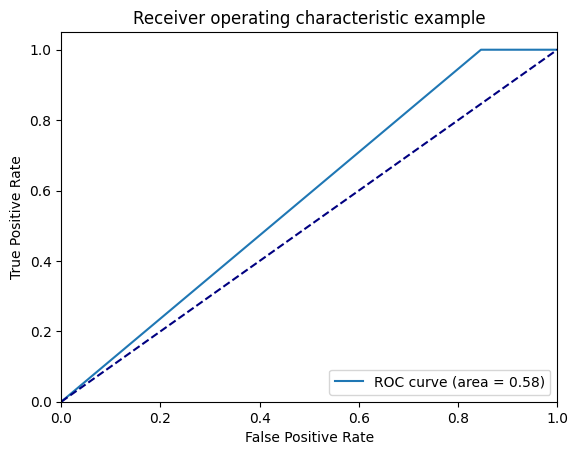

In [10]:
fpr, tpr, th = metrics.roc_curve(y_test, y_pred)
# Sensitivty = TPR(True Positive Rate) = Recall = TP/(TP+FN)
# (1 - Specificity) = FPR(False Positive Rate) = FP/(TN+FP)

roc_auc = metrics.roc_auc_score(y_test, y_pred)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show();

# plt.figure()
# RocCurveDisplay.from_predictions(y_test, y_pred)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.show();

Multiclass classification

Classes: [0 1 2]
Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.5290 - accuracy: 0.1905 - val_loss: 1.4905 - val_accuracy: 0.0952
Epoch 2/100
1/1 [==============================] - 0s 63ms/step - loss: 1.5189 - accuracy: 0.2024 - val_loss: 1.4819 - val_accuracy: 0.0952
Epoch 3/100
1/1 [==============================] - 0s 82ms/step - loss: 1.5089 - accuracy: 0.2262 - val_loss: 1.4733 - val_accuracy: 0.0952
Epoch 4/100
1/1 [==============================] - 0s 58ms/step - loss: 1.4990 - accuracy: 0.2381 - val_loss: 1.4648 - val_accuracy: 0.0952
Epoch 5/100
1/1 [==============================] - 0s 87ms/step - loss: 1.4892 - accuracy: 0.2738 - val_loss: 1.4564 - val_accuracy: 0.0952
Epoch 6/100
1/1 [==============================] - 0s 99ms/step - loss: 1.4795 - accuracy: 0.3214 - val_loss: 1.4480 - val_accuracy: 0.1905
Epoch 7/100
1/1 [==============================] - 0s 65ms/step - loss: 1.4698 - accuracy: 0.3214 - val_loss: 1.4398 - val_accuracy: 0.1905
Epoch

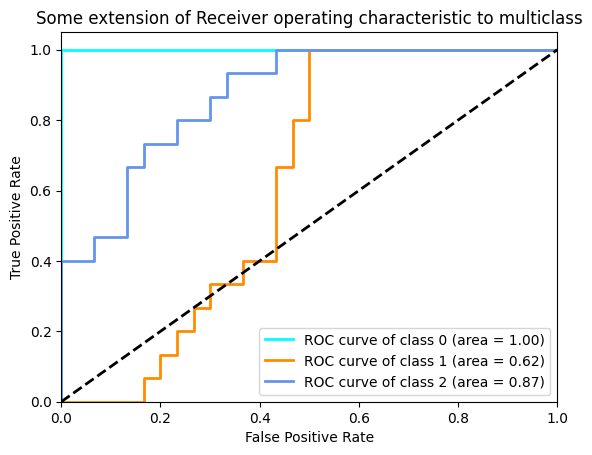

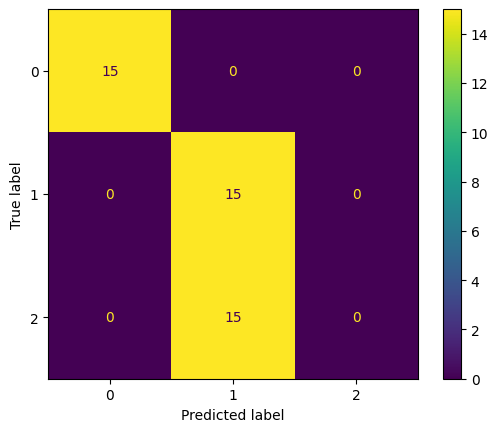

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Import data
iris = datasets.load_iris()
X = iris.data
y = iris.target

print(f'Classes: {np.unique(y)}')

# Binarize the output
y = np.array(pd.get_dummies(y))
num_classes = y.shape[1]

n_samples, n_features = X.shape

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Create the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(10, input_shape=(n_features,), activation='tanh'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=X_train.shape[0], validation_split=0.2)

# Test the model after training
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

# Probabilty estimates
y_score = np.array(model.predict(X_test))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multiclass')
plt.legend(loc='lower right')
plt.show()

y_pred = np.argmax(y_score, axis=1)
y_test = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=['0', '1'])
disp.plot()
plt.show()

## Regression evaluation metrcis

Epoch 1/100
2/2 [==============================] - 2s 375ms/step - loss: 150.8683 - mean_absolute_error: 150.8683 - val_loss: 155.3294 - val_mean_absolute_error: 155.3294
Epoch 2/100
2/2 [==============================] - 0s 77ms/step - loss: 150.7011 - mean_absolute_error: 150.7011 - val_loss: 155.1717 - val_mean_absolute_error: 155.1717
Epoch 3/100
2/2 [==============================] - 0s 70ms/step - loss: 150.5366 - mean_absolute_error: 150.5366 - val_loss: 155.0149 - val_mean_absolute_error: 155.0149
Epoch 4/100
2/2 [==============================] - 0s 47ms/step - loss: 150.3719 - mean_absolute_error: 150.3719 - val_loss: 154.8564 - val_mean_absolute_error: 154.8564
Epoch 5/100
2/2 [==============================] - 0s 43ms/step - loss: 150.2065 - mean_absolute_error: 150.2065 - val_loss: 154.6948 - val_mean_absolute_error: 154.6948
Epoch 6/100
2/2 [==============================] - 0s 42ms/step - loss: 150.0377 - mean_absolute_error: 150.0377 - val_loss: 154.5286 - val_mean_abso

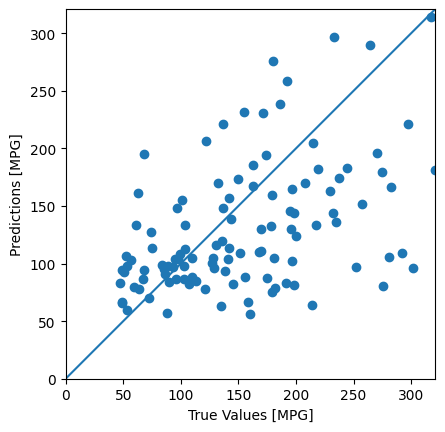

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf

# Import data
# dataset = datasets.fetch_california_housing()
dataset = datasets.load_diabetes()
X = dataset.data
y = dataset.target

n_samples, n_features = X.shape

# Shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# Create the model
model = tf.keras.Sequential()
model.add(normalizer)
model.add(tf.keras.layers.Dense(64, input_shape=(n_features,), activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

# Configure the model and start training
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)

# Test the model after training
test_results = model.evaluate(X_test, y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - MAE: {test_results[1]}%')

y_pred = model.predict(X_test)

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
#plt.plot(test_labels, np.abs(test_labels - test_predictions), color='k')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, np.max(y_test)]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [13]:
metrics.explained_variance_score(y_test, y_pred)

0.1186065247976612

In [14]:
metrics.max_error(y_test, y_pred)

206.02361297607422

In [15]:
metrics.mean_absolute_error(y_test, y_pred)

54.08852389911274

In [16]:
# MSE 
metrics.mean_squared_error(y_test, y_pred, squared=True)

4898.37032422091

In [17]:
# RMSE
metrics.mean_squared_error(y_test, y_pred, squared=False)

69.98835849068693

In [18]:
# Mean squared logarithmic error regression loss.
metrics.mean_squared_log_error(y_test, y_pred)

0.23775204587032595

In [19]:
metrics.median_absolute_error(y_test, y_pred)

44.7396240234375

In [20]:
# R^2 (coefficient of determination) regression score function.
metrics.r2_score(y_test, y_pred)

0.013303339297500827